## Hello visitor,

The following analysis and clustering is done on a text dataset of news headlines extracted from twitter. I found this dataset on UCI Machine Learning repository and though I'd give a try doing something with it. The following is in accordance with the tutorial i found in kdnuggets though I "might" have missed some parts, haha. Now, behold my #### Failed attempt in doing something with this dataset. You may go through this, and you will definitely find mistakes and improvements. Please post them in the comment section if you find any. So me and anyone who visits this can benefit from it. 

In [1]:
#We shall import some stuff here

import pandas as pd
import numpy as np
import re
import string

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib inline

In [3]:
# Initializing a lemmatizer
lemmatizer = WordNetLemmatizer()

In [4]:
# Lets open the file and and extract all the content line by line into a list
with open('../input/bbchealth.txt') as file:
    contents = file.readlines()
    
# Fancy regex for extracting data. Because I'm awesome and I refuse to split it.
regex = re.compile(r'(?P<tweet_id>.*)\|(?P<date>.*)\|(?P<news>.*)\s?(?P<link>http://.*)')

In [5]:
# I hope the regex words
re.search(regex, contents[0]).groupdict()

# And it worked. Cool

{'tweet_id': '585978391360221184',
 'date': 'Thu Apr 09 01:31:50 +0000 2015',
 'news': 'Breast cancer risk test devised ',
 'link': 'http://bbc.in/1CimpJF'}

In [6]:
# You all know this. Don't pretend that you don't.
df = pd.DataFrame(columns=['tweet_id', 'date', 'news', 'link'])

# Self explanatory
for line in contents:
    line_data = re.search(regex, line).groupdict()
    df = df.append(line_data, ignore_index=True)

In [7]:
# Our dataset looks like this. Not too shabby.
df.head()

,tweet_id,date,news,link
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,http://bbc.in/1CimpJF
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,http://bbc.in/1ChTBRv
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',http://bbc.in/1ChTANp
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',http://bbc.in/1E6jAjt
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,http://bbc.in/1CnLwK7


In [8]:
# Lets define some function to normalize, lemmatize the line and getting POS tags. 
# Normalizing, the following methods in order -- lower, strip white spaces, remove punctiations and 
# digits, and finally word tokenizing

def normalize(line):
    line = line.lower().strip()
    line = ''.join([char for char in line if char not in string.punctuation+string.digits])
    return word_tokenize(line)

# Lemmatizing each word in each line
def lemmatize_sent(line_tokens):
    return list(map(lemmatizer.lemmatize, line_tokens))

# POS tagging, This one returns just the POS tags in order.
def tokens(line_tokens):
    word_tags = pos_tag(line_tokens)
    return list(zip(*word_tags))[1]

In [9]:
# Let's apply all those functions to the columns.
df['news_tokens'] = df['news'].map(normalize)
df['corresponding_tags'] = df['news_tokens'].map(tokens)
df['lemmatized_news_tokens'] = df['news_tokens'].map(lemmatize_sent)

In [10]:
# Dropping unnecessary columns, that I think I don't need.
df.drop(labels=['link'], inplace=True, axis=1)
df.drop(labels=['tweet_id'], inplace=True, axis=1)

In [11]:
# Let's see what our dataset looks like again
df.head()

,date,news,news_tokens,corresponding_tags,lemmatized_news_tokens
0,Thu Apr 09 01:31:50 +0000 2015,Breast cancer risk test devised,"[breast, cancer, risk, test, devised]","(NN, NN, NN, NN, VBD)","[breast, cancer, risk, test, devised]"
1,Wed Apr 08 23:30:18 +0000 2015,GP workload harming care - BMA poll,"[gp, workload, harming, care, bma, poll]","(NN, NN, VBG, NN, NN, NN)","[gp, workload, harming, care, bma, poll]"
2,Wed Apr 08 23:30:18 +0000 2015,Short people's 'heart risk greater',"[short, peoples, heart, risk, greater]","(JJ, NNS, NN, NN, JJR)","[short, people, heart, risk, greater]"
3,Wed Apr 08 18:05:28 +0000 2015,New approach against HIV 'promising',"[new, approach, against, hiv, promising]","(JJ, NN, IN, NN, NN)","[new, approach, against, hiv, promising]"
4,Wed Apr 08 13:19:33 +0000 2015,Coalition 'undermined NHS' - doctors,"[coalition, undermined, nhs, doctors]","(NN, VBD, JJ, NNS)","[coalition, undermined, nh, doctor]"


In [12]:
# Now that we've cleaned and prepared our dataset, let's do some transformation
# We'll create a tfidf matrix of all the documents. 
# Tfidf is generally used in document similarity. Because the dot product followed by division by the their
# normals give you their cosine similarity.
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['lemmatized_news_tokens'].map(lambda x: ' '.join(x)).tolist())

In [13]:
# Let's do some actual machine learning now. We'll be doing KMeans for now.
# Let's take the default value for number of clusters(n_clusters=8).
# because we don't know any crap.
# And later use elbow method and silhoutte score to find the right number of 
# clusters
kmeans = KMeans()
kmeans.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
# Yup, right number of labels.
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [15]:
tfidf_matrix

<3929x3938 sparse matrix of type '<class 'numpy.float64'>'
	with 22121 stored elements in Compressed Sparse Row format>

In [16]:
# Now, plotting time. But we can't just plot a sparse matrix of size 3929x3955.
# That's stupid. So, let's trim down the dimensions to 2.
# This is going to lose some information, but do we have a choice?
pca = PCA(n_components=2)
pca_matrix = pca.fit_transform(tfidf_matrix.A)

(-0.4, 0.4)

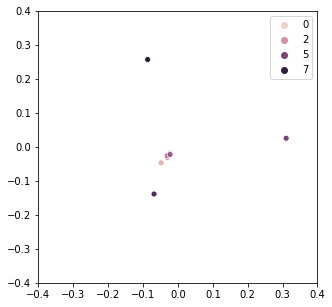

In [17]:
# Let's plot the cluster centers
plt.figure(figsize=(5, 5))
cluster_centers = pca.fit_transform(kmeans.cluster_centers_)
sns.scatterplot(x=cluster_centers[:,0], y=cluster_centers[:,1], hue=np.unique(kmeans.labels_))
    
plt.xlim((-0.4, 0.4))
plt.ylim((-0.4, 0.4))

# Oh well. Horrible.

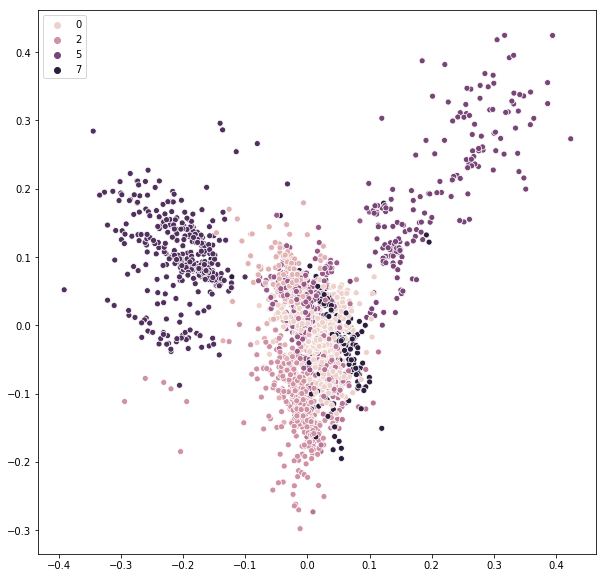

In [18]:
# Plotting the whole data, we get the following graph.
plt.figure(figsize=(10, 10))
sns.scatterplot(x=pca_matrix[:,0], y=pca_matrix[:,1], hue=kmeans.labels_)

In [19]:
# Did you just think we're gonna stop at 2D plots?
# If you did, you're wrong buddy. Behold 3D plots.
pca_3d = PCA(n_components=3)
pca_matrix_3d = pca_3d.fit_transform(tfidf_matrix.A)

/opt/conda/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


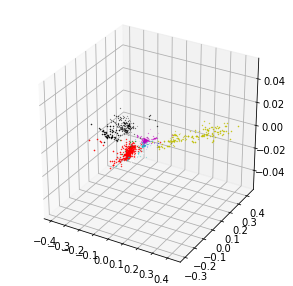

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
for p, l in zip(pca_matrix_3d, kmeans.labels_):
    plt.scatter(*p, 'bgrcmykw'[l])

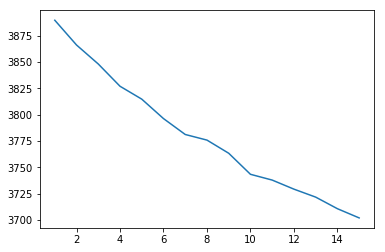

In [21]:
# Now, for elbow method. We'll try clustering from k=1 to k=15 and see how well the curve is displayed
x, y = [], []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tfidf_matrix)
    x.append(k)
    y.append(kmeans.inertia_)
    
plt.plot(x, y)

In [22]:
# That suck. Where's the elbow?
# Let's see how sihoutte score goes.
# For those who doesn't know what silhoutte score is,
# The silhoutte score is a value of measure of closeness
# to it's own cluster(cohesion) compared to other clusters(seperation)
# it ranges from [-1, 1]. A high value indicates how well matched is
# an object is to it's cluster.
# For more info, wikipedia is your guy.

# We'll calculate silhoutte scores for the same range as before excpet 1
# Because it'll throw an error if k = 1. Because you know,
# how well a point is matched to it's cluster and there exists one cluster.
# Make sense to you. It doesn't to me.

In [23]:
for k in range(2, 16):
    kmeans = KMeans(n_clusters=k).fit(tfidf_matrix)
    sil_score = silhouette_score(tfidf_matrix, kmeans.labels_)
    print('Number of clusters: {}, Silhoutte Score: {}'.format(k, sil_score))

Number of clusters: 2, Silhoutte Score: 0.003910436812627539
Number of clusters: 3, Silhoutte Score: 0.005376067097764778
Number of clusters: 4, Silhoutte Score: 0.006751676443807007
Number of clusters: 5, Silhoutte Score: 0.008164202785336718
Number of clusters: 6, Silhoutte Score: 0.00889128859289345
Number of clusters: 7, Silhoutte Score: 0.010671523513903339
Number of clusters: 8, Silhoutte Score: 0.01074044985054451
Number of clusters: 9, Silhoutte Score: 0.011708377517561439
Number of clusters: 10, Silhoutte Score: 0.01306196907301487
Number of clusters: 11, Silhoutte Score: 0.01421579659487561
Number of clusters: 12, Silhoutte Score: 0.014785601314514245
Number of clusters: 13, Silhoutte Score: 0.014775916409408068
Number of clusters: 14, Silhoutte Score: 0.01587972258912836
Number of clusters: 15, Silhoutte Score: 0.015409020676227151


In [24]:
# That's not nice, the silhoutte score is still going up.
# No matters, now this is where you come in visitor. If you find
# something, please post it in the comment section. It can be 
# suggestions, imrpovements, or errors. 